# Numerical Solvers

In [110]:
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt

## 1. Moisture Gain -- without experimental data

In [111]:
# GAB model parameters
# based on a packaged cassava-flour-based baked product(from literature: doi:10.1016/j.jfoodeng.2010.04.031)
W_m = 2.5 # monolayer moisture content(g water / g dry solids)
C = 49.1
K = 1.1 

# packaging parameters
P_w = 1e-12 # water vapour permeability of the package
A = 0.015 # surface area
L = 1e-4 # thickness
p_0 = 3170  # saturation vapour pressure of water (T = 25°C)
W_s = 0.05 # mass of dry solids of the food
aw_env = 0.6 # environmental water activity
aw_c = 0.55 # critical water activity of the food

In [112]:
def w(aw):
    return W_m * C * K * aw / ((1 - K * aw) * (1 - K * aw + C * K * aw))

def S(aw):
    delta = 1e-5
    return (w(aw+delta) - w(aw-delta)) / (2 * delta)

def daw_dt(t, aw):
    if S(aw[0])<= 0:
        return [0.0]
    return [(P_w * A * p_0 * (aw_env - aw[0])) / (W_s * L * S(aw[0]))]

In [113]:
aw_0 = 0.3
t_span = (0, 1e7)
solver = solve_ivp(daw_dt, t_span, [aw_0], method='RK45', dense_output=True, max_step=100)

t_c = None
for t,aw in zip(solver.t, solver.y[0]):
    if aw >= aw_c:
        t_c = t/(60*60*24)
        break

if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 26.83352097 days


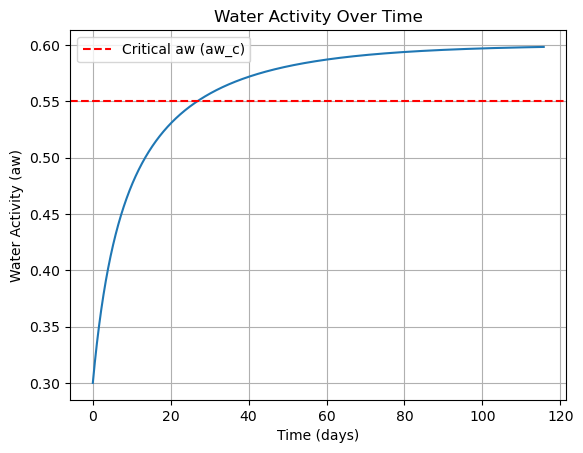

In [114]:
plt.plot(solver.t/(60*60*24), solver.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Water Activity (aw)')
plt.title('Water Activity Over Time')
plt.axhline(y=aw_c, color='r', linestyle='--', label='Critical aw (aw_c)')
plt.legend()
plt.grid()
plt.show()

## * 1. Moisture Gain - with experimental data

### 1.1 Reading data and visualisation

In [115]:
data = pd.ExcelFile('gab_test_data.xlsx')
saltin_df = data.parse('Saltin_25')
snack_qa_df = data.parse('Snack_Q_A_25')

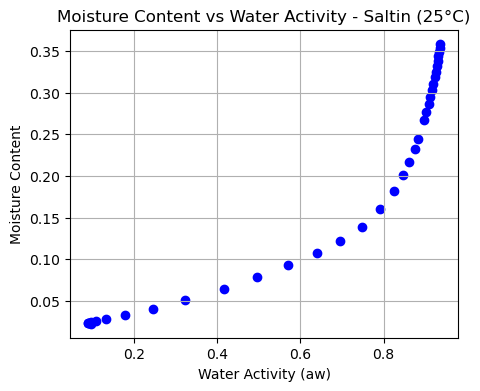

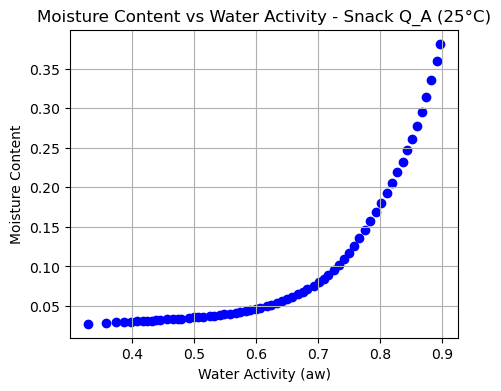

In [116]:
def plot_scatter(df, name):
    aw = df['aw']
    moisture = df['moisture']

    plt.figure(figsize=(5,4))
    plt.scatter(aw, moisture, color='blue')
    plt.xlabel('Water Activity (aw)')
    plt.ylabel('Moisture Content')
    plt.title(f'Moisture Content vs Water Activity - {name} (25°C)')
    plt.grid()
    plt.show()

plot_scatter(saltin_df, 'Saltin')
plot_scatter(snack_qa_df, 'Snack Q_A')

### 1.2 Finding GAB parameters using curve fitting

In [117]:
def gab_model(aw, W_m, C, K):
    return W_m * C * K * aw / ((1 - K * aw) * (1 - K * aw + C * K * aw))

def fit_gab_model(aw, w, init_params=None):
    if init_params is not None:
        params, _ = curve_fit(gab_model, aw, w, p0=init_params, maxfev=10000)
        return params

In [118]:
# GAB model parameters - initial guess
W_m = 0.05
C = 10.0
K = 0.8
init_params = [W_m, C, K]

In [119]:
params_saltin = fit_gab_model(saltin_df['aw'], saltin_df['moisture'], init_params=init_params)
params_snack_qa = fit_gab_model(snack_qa_df['aw'], snack_qa_df['moisture'], init_params=init_params)

print("Fitted parameters for Saltin:", params_saltin)
print("Fitted parameters for Snack_Q_A:", params_snack_qa)

Fitted parameters for Saltin: [ 0.04212285 11.66984788  0.94269247]
Fitted parameters for Snack_Q_A: [2.80659747 0.0073687  0.88782258]


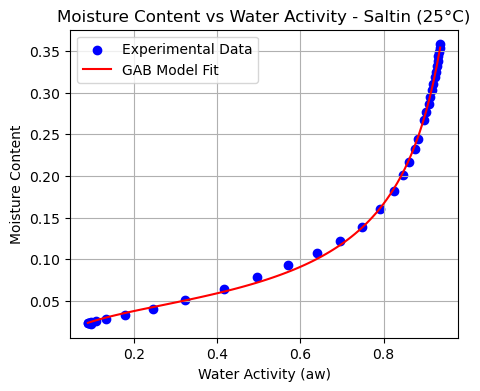

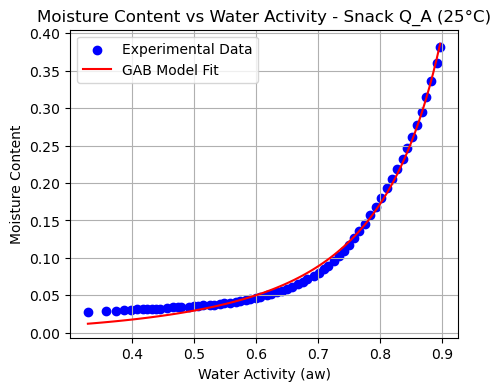

In [120]:
def fitted_plot(df, params, name):
    aw = df['aw']
    moisture = df['moisture']
    aw_fit = np.linspace(min(aw), max(aw), 100)
    W_m, C, K = params
    moisture_fit = gab_model(aw_fit, W_m, C, K)

    plt.figure(figsize=(5,4))
    plt.scatter(aw, moisture, color='blue', label='Experimental Data')
    plt.plot(aw_fit, moisture_fit, color='red', label='GAB Model Fit')
    plt.xlabel('Water Activity (aw)')
    plt.ylabel('Moisture Content')
    plt.title(f'Moisture Content vs Water Activity - {name} (25°C)')
    plt.legend()
    plt.grid()
    plt.show()

fitted_plot(saltin_df, params_saltin, 'Saltin')
fitted_plot(snack_qa_df, params_snack_qa, 'Snack Q_A')

### 1.3 Calculating shelf life
#### 1.3.1 Using time stepping methods to solve the ODE

In [121]:
# packaging parameters
P_w = 1e-12 # water vapour permeability of the package
A = 0.01 # surface area
L = 1e-3 # thickness
p_0 = 3170  # saturation vapour pressure of water (T = 30°C)
W_s = 0.05 # mass of dry solids of the food
aw_env = 0.6 # environmental water activity
aw_c = 0.5 # critical water activity of the food

In [122]:
def S_exp(aw, W_m, C, K):
    delta = 1e-5
    return (gab_model(aw+delta, W_m, C, K) - gab_model(aw-delta, W_m, C, K)) / (2 * delta)

def daw_dt_exp(t, aw, W_m, C, K):
    slope = S_exp(aw[0], W_m, C, K)
    if slope<= 0 or np.isnan(slope):
        return [0.0]
    return [(P_w * A * p_0 * (aw_env - aw[0])) / (W_s * L * slope)]

In [123]:
aw_0 = 0.05
t_span = (0, 1e7)
W_m, C, K = params_saltin  # Using Saltin parameters for the simulation
solver = solve_ivp(lambda t, aw: daw_dt_exp(t, aw, W_m, C, K), t_span, [aw_0], method='RK45', dense_output=True, max_step=100)

t_c = None
for t,aw in zip(solver.t, solver.y[0]):
    if aw >= aw_c:
        t_c = t/(60*60*24)
        break

if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 3.91422880 days


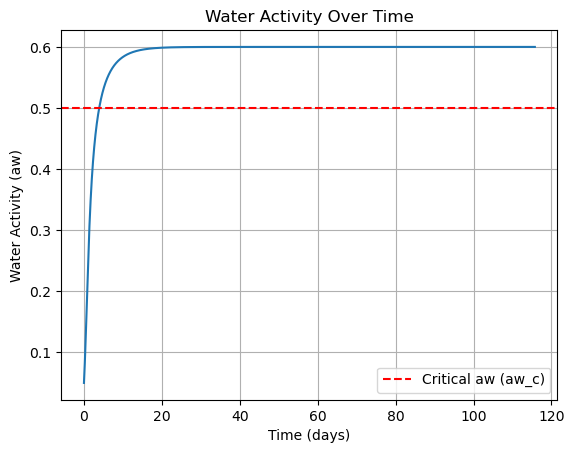

In [124]:
plt.plot(solver.t/(60*60*24), solver.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Water Activity (aw)')
plt.title('Water Activity Over Time')
plt.axhline(y=aw_c, color='r', linestyle='--', label='Critical aw (aw_c)')
plt.legend()
plt.grid()
plt.show()

#### 1.3.2 Using numerical integration methods (Scipy: Adaptive Gauss-Legendre Quadrature)

In [125]:
def integrand(aw, W_m, C, K):
    slope = S_exp(aw, W_m, C, K)
    delta_aw = (aw_env - aw)
    if slope <= 0 or np.isnan(slope) or delta_aw <= 0:
        return 0.0
    return (W_s * L * slope) / (P_w * A * p_0 * delta_aw)

In [126]:
W_m, C, K = params_saltin  # Using Saltin parameters for the simulation
t, aw = quad(lambda aw: integrand(aw, W_m, C, K), aw_0, aw_c)

t_c = t / (60*60*24)
if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 3.91331077 days


#### 1.3.3 Using numerical integration methods (Manually: Trapezoidal Rule)

In [127]:
N = 1000
aw_vals = np.linspace(aw_0, aw_c, N + 1)
h = (aw_c - aw_0) / N

f_vals = np.array([integrand(aw, W_m, C, K) for aw in aw_vals]) # calculate the function values at each aw
t = h * (0.5 * f_vals[0] + np.sum(f_vals[1:-1]) + 0.5 * f_vals[-1]) # trapezoidal rule

t_c = t / (60*60*24)
if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 3.91331807 days


## 2. Lipid Oxidation

In [128]:
# parameters
E_a = 50000  # Activation energy in J/mol
Z = 1e6  # Pre-exponential factor in 1/s
R = 8.314  # Universal gas constant in J/(mol*K)
T_list = np.array([268, 273, 278, 283, 288, 293, 298, 303, 308, 313, 318])  # Temperatures in Kelvin

def k(T):
    return Z * np.exp(-E_a / (R * T))

k_ox = k(T_list)
t_ox = 1 / k_ox  # Oxidation time in seconds

print("Oxidation times at different temperatures (in seconds):")
for T, t in zip(T_list, t_ox):
    print(f"T = {T} K, t_ox = {t:.2f} s")


Oxidation times at different temperatures (in seconds):
T = 268 K, t_ox = 5566.99 s
T = 273 K, t_ox = 3690.88 s
T = 278 K, t_ox = 2483.47 s
T = 283 K, t_ox = 1694.60 s
T = 288 K, t_ox = 1171.77 s
T = 293 K, t_ox = 820.51 s
T = 298 K, t_ox = 581.46 s
T = 303 K, t_ox = 416.76 s
T = 308 K, t_ox = 301.96 s
T = 313 K, t_ox = 221.05 s
T = 318 K, t_ox = 163.41 s


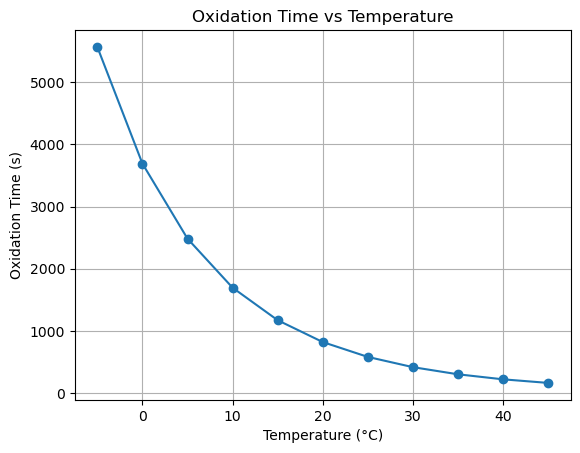

In [129]:
plt.plot(T_list - 273, t_ox, marker='o')
plt.xlabel('Temperature (°C)')
plt.ylabel('Oxidation Time (s)')
plt.title('Oxidation Time vs Temperature')
plt.grid()
plt.show()